# YouTube trending videos

In [2]:
%matplotlib inline
import json
import math
import os
import re
from IPython.display import Image

from images_downloading import ImageSize

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from tqdm.notebook import tqdm

from categories import get_categories_dict
from split import split_csv
from tokenizers import Tokenizer, RE_HTTP

[nltk_data] Downloading package stopwords to /home/michal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Etap 2 - Atrybuty wizualne


### Wczytanie danych zgrupowanych po id

In [3]:
data_path = "youtube_grouped_by_id_all_list"
gb_videos = pd.read_pickle(os.path.join(data_path, "GB_videos_5p.plk"))
us_videos = pd.read_pickle(os.path.join(data_path, "US_videos_5p.plk"))
videos = pd.concat([gb_videos, us_videos])
videos = videos.rename(columns={"description ":"description"})
videos.head(10)

size = ImageSize.hqdefault.default
images_path = os.path.join("images")
gb_images = pd.read_pickle(os.path.join(images_path, f"GB_{size}.plk"))
us_images = pd.read_pickle(os.path.join(images_path, f"US_{size}.plk"))

videos_images = pd.concat([gb_images, us_images])
videos_images = videos_images.rename(columns={"description ":"description"})
videos_images.head(10)


,number,id,count,thumbnail_path,error,status
0,0,--uXQQ0h-yQ,9,[images/default/0_GB_--uXQQ0h-yQ_0.jpg],[False],[200]
0,1,-3VBPAZPTQI,14,[images/default/1_GB_-3VBPAZPTQI_0.jpg],[False],[200]
0,2,-43MBOJnVks,2,[images/default/2_GB_-43MBOJnVks_0.jpg],[False],[200]
0,3,-5WBCrazSfg,10,[images/default/3_GB_-5WBCrazSfg_0.jpg],[False],[200]
0,4,-5aaJJQFvOg,34,[images/default/4_GB_-5aaJJQFvOg_0.jpg],[False],[200]
0,5,-7tSTUR7FG0,15,[images/default/5_GB_-7tSTUR7FG0_0.jpg],[False],[200]
0,6,-8X32zNup1o,9,[ERROR],[True],[404]
0,7,-A9rYcBmBFo,9,[images/default/7_GB_-A9rYcBmBFo_0.jpg],[False],[200]
0,8,-B7J36GNaDk,6,[images/default/8_GB_-B7J36GNaDk_0.jpg],[False],[200]
0,9,-BDImdAfodA,32,[images/default/9_GB_-BDImdAfodA_0.jpg],[False],[200]


Najczęściej występujące obrazy w obu zobu zbiorów

**Wielka Brytania**

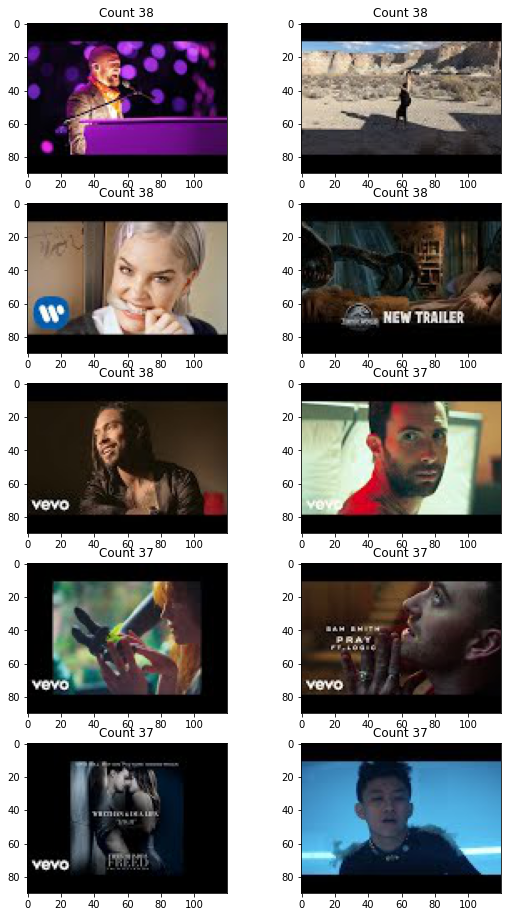

In [3]:
n_top = 10
columns = 2

gb_top = gb_images.nlargest(n_top, "count")

fig, axs = plt.subplots(n_top // columns, columns,figsize=(9,16)) # , gridspec_kw={'height_ratios': [1, 2]}
for i in range(n_top // 2):
    for j in range(columns):
        index = i * columns + j
        image_path = gb_top["thumbnail_path"].iloc[index][0]
        count = gb_top["count"].iloc[index]
        image = mpimg.imread(image_path)
        axs[i][j].title.set_text(f"Count {count}")
        axs[i][j].imshow(image)

**Stany Zjednoczone**

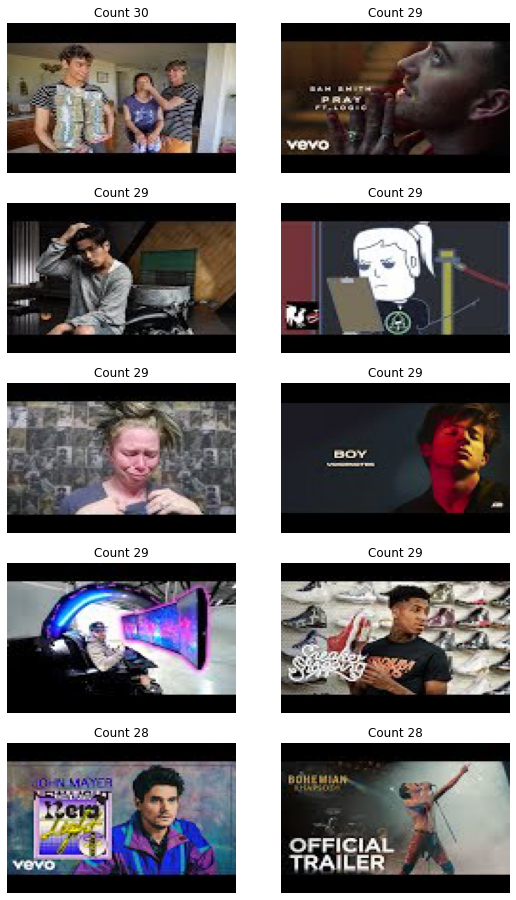

In [23]:
us_top = us_images.nlargest(n_top, "count")

fig, axs = plt.subplots(n_top // columns, columns,figsize=(9,16)) # , gridspec_kw={'height_ratios': [1, 2]}
for i in range(n_top // 2):
    for j in range(columns):
        index = i * columns + j
        image_path = us_top["thumbnail_path"].iloc[index][0]
        count = us_top["count"].iloc[index]
        image = mpimg.imread(image_path)
        axs[i][j].title.set_text(f"Count {count}")
        axs[i][j].axis('off')
        axs[i][j].imshow(image, aspect='auto')

## Histogramy
### Czarno białe

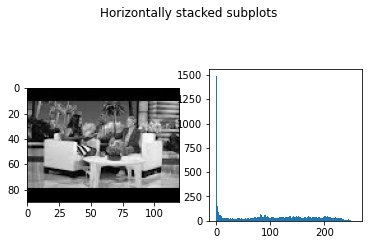

In [4]:
import cv2
import numpy as np


img = cv2.imread('images/default/0_US_-0CMnp02rNY_0.jpg',0)


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')

ax1.imshow(img, cmap='gray')
ax2.hist(img.ravel(),256,[0,256])
asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
ax2.set_aspect(asp)

plt.show()

[1842.]
[1856.]
[1758.]


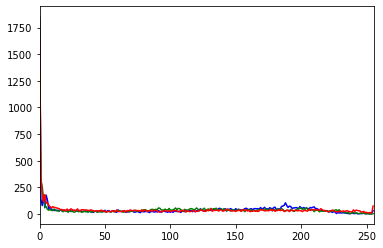

In [30]:
img = cv2.imread('images/default/0_US_-0CMnp02rNY_0.jpg')
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
#     print(histr)
#     print(type(histr))
    print(max(histr))
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

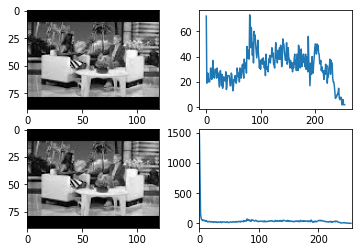

[1491.] [73.]


In [40]:
img = cv2.imread('images/default/0_US_-0CMnp02rNY_0.jpg',0)

# create a mask
mask = np.zeros(img.shape[:2], np.uint8)
mask[11:-11,:] = 255
masked_img = cv2.bitwise_and(img,img,mask = mask)

# Calculate histogram with mask and without mask
# Check third argument for mask
hist_full = cv2.calcHist([img],[0],None,[256],[0,256])
hist_mask = cv2.calcHist([img],[0],mask,[256],[0,256])
plt.subplot(221), plt.imshow(img, 'gray')
plt.subplot(222), plt.plot(hist_mask) #plt.imshow(mask,'gray') 
plt.subplot(223), plt.imshow(masked_img, 'gray')
plt.subplot(224), plt.plot(hist_full)
plt.xlim([0,256])
plt.show()
print(max(hist_full), max(hist_mask))

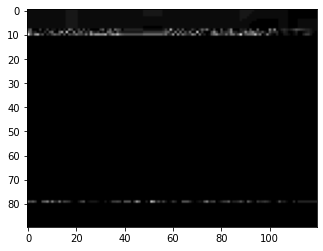

In [43]:
test_img = cv2.bitwise_xor(img,masked_img)
plt.imshow(test_img, 'gray')

In [59]:
for i in range(img.shape[0]):
    print (i,np.sum(img[i,:]), np.sum(mask[i,:]))

0 127 0
1 126 0
2 125 0
3 116 0
4 113 0
5 110 0
6 109 0
7 101 0
8 347 0
9 460 0
10 790 0
11 12009 30600
12 10892 30600
13 10617 30600
14 12552 30600
15 12488 30600
16 11153 30600
17 10809 30600
18 12674 30600
19 11919 30600
20 10655 30600
21 11587 30600
22 12486 30600
23 12992 30600
24 11549 30600
25 12451 30600
26 12699 30600
27 12358 30600
28 13481 30600
29 14143 30600
30 14470 30600
31 13282 30600
32 13153 30600
33 13667 30600
34 13020 30600
35 10208 30600
36 13156 30600
37 13463 30600
38 12201 30600
39 10848 30600
40 11486 30600
41 13277 30600
42 15224 30600
43 17796 30600
44 18520 30600
45 17297 30600
46 15626 30600
47 15625 30600
48 16545 30600
49 16341 30600
50 17044 30600
51 17376 30600
52 18289 30600
53 19240 30600
54 20543 30600
55 21386 30600
56 20238 30600
57 20505 30600
58 21055 30600
59 21032 30600
60 20300 30600
61 20665 30600
62 17736 30600
63 14950 30600
64 12442 30600
65 9971 30600
66 9679 30600
67 10975 30600
68 12103 30600
69 13312 30600
70 15115 30600
71 17291 3060

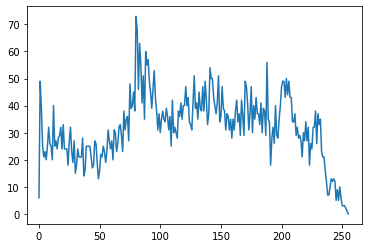

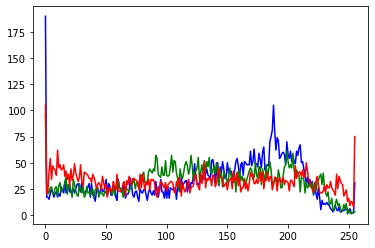

In [66]:
img = cv2.imread('images/default/0_US_-0CMnp02rNY_0.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# create a mask
mask = np.zeros(img.shape[:2], np.uint8)
mask[11:-11,:] = 255

hist_gray = cv2.calcHist([gray],[0],mask,[256],[0,256])
plt.plot(hist_gray)
plt.xlim([-10,266])
plt.show()

color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],mask,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([-10,266])
plt.show()

In [129]:
def get_hist(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # create a mask
    mask = np.zeros(img.shape[:2], np.uint8)
    mask[11:-11,:] = 255

    hist_gray = cv2.calcHist([gray],[0],mask,[256],[0,256])
#     plt.plot(hist_gray)
#     plt.xlim([-10,266])
#     plt.show()

    hists = []
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],mask,[256],[0,256])
        hists.append(histr)
#         plt.plot(histr,color = col)
#         plt.xlim([-10,266])
#     plt.show()
    
    return hist_gray, hists
    
    
def draw_hist(hist, color=True):
    if not color:
        plt.plot(hist)
    else:
#         plt.subplot(131), plt.plot(hist[0],color = 'b')
#         plt.subplot(132), plt.plot(hist[1],color = 'g')
#         plt.subplot(133), plt.plot(hist[2],color = 'r')
        for hst,col in zip(hist, ('b','g','r')):
            plt.plot(hst,color = col)
    plt.xlim([-10,266])
    plt.show()


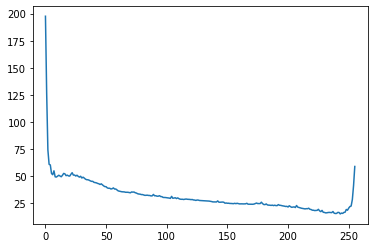

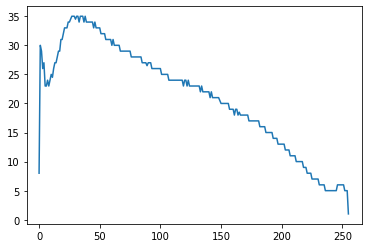

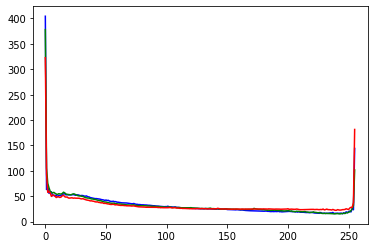

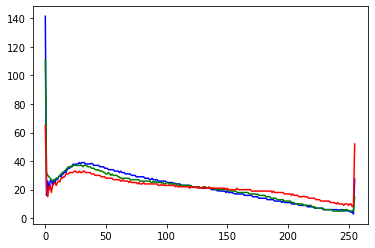

In [132]:
grays = []
colors = []
for index in range(gb_images.shape[0]):
    if not gb_images["error"].iloc[index][0]:
        image_path = gb_images["thumbnail_path"].iloc[index][0]
#         print(image_path)
        img = cv2.imread(image_path)
#         img = cv2.imread('images/default/0_US_-0CMnp02rNY_0.jpg')

        g,c = get_hist(img)
        grays.append(g)
        colors.append(c)
gray = np.mean(grays, axis = 0)
gray_med = np.median(grays, axis = 0)
color = list(zip(*colors))
# print(len(col), len(col[0]))
color_mean = [np.mean(x, axis = 0) for x in color]
color_median = [np.median(x, axis = 0) for x in color]
# color = np.mean(col, axis = 0)

draw_hist(gray,False)
draw_hist(gray_med,False)
draw_hist(color_mean,True)
draw_hist(color_median,True)

## Entropia

In [53]:
def entropy(signal):
        lensig=signal.size
        symset=list(set(signal))
        numsym=len(symset)
        propab=[np.size(signal[signal==i])/(1.0*lensig) for i in symset]
        ent=np.sum([p*np.log2(1.0/p) for p in propab])
        return ent
    
    
def layer_entropy(img,N=5):
    S=img.shape
    E=np.array(img)
    for row in range(S[0]):
          for col in range(S[1]):
            Lx=np.max([0,col-N])
            Ux=np.min([S[1],col+N])
            Ly=np.max([0,row-N])
            Uy=np.min([S[0],row+N])
            region=img[Ly:Uy,Lx:Ux].flatten()
            E[row,col]=entropy(region)
    return E

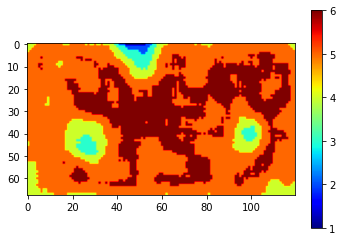

In [47]:
img = cv2.imread('images/default/0_US_-0CMnp02rNY_0.jpg',0)
img = img[11:-11,:]
img = layer_entropy(img,5)
plt.imshow(img, cmap=plt.cm.jet)
plt.colorbar()

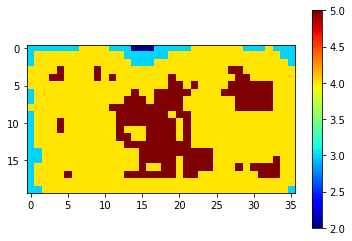

In [57]:
img = cv2.imread('images/default/0_US_-0CMnp02rNY_0.jpg',0)
img = img[11:-11,:]
scale = 0.3
img = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
img = layer_entropy(img,3)
plt.imshow(img, cmap=plt.cm.jet)
# plt.imshow(img)
plt.colorbar()

In [55]:
def calc_entropy(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img[11:-11,:]
    scale = 0.3
    img = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
    img = layer_entropy(img,3)
    
    return img
    
def show_entropy(img):
    plt.imshow(img, cmap=plt.cm.jet)
    plt.colorbar()
    plt.show()

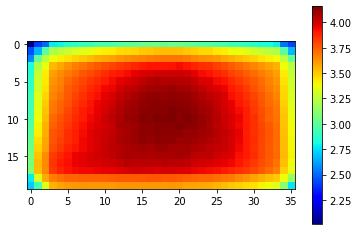

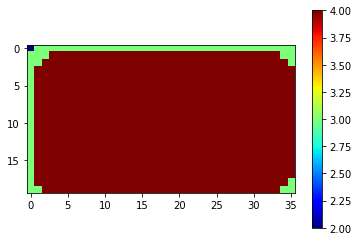

In [57]:
imgs = []
for index in range(gb_images.shape[0]):
# for index in range(10):
    if not gb_images["error"].iloc[index][0]:
        image_path = gb_images["thumbnail_path"].iloc[index][0]
        img = cv2.imread(image_path)
        
        img = calc_entropy(img)
        imgs.append(img)

img_mean = np.mean(imgs, axis = 0)
img_med = np.median(imgs, axis = 0)

show_entropy(img_mean)
show_entropy(img_med)
# 5-10 min obliczen

## Średnie pikseli

[97.58064755600051, 97.99854162835679, 109.00887903615771]
[83.0, 84.0, 98.0]
[68.28098821588378, 94.88652458812633, 121.39124364056148]
[56.0, 79.0, 118.0]


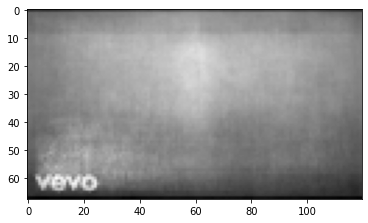

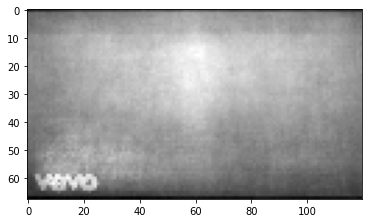

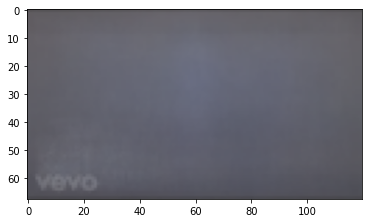

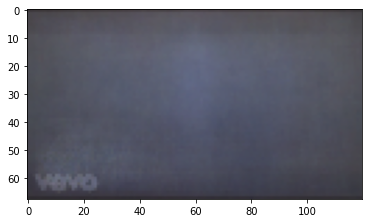

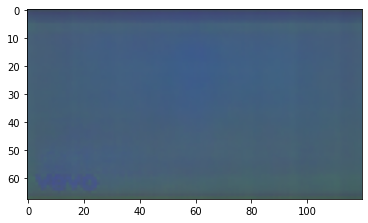

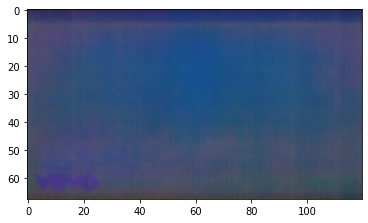

In [73]:
grays = []
colors = []
hsvs = []
for index in range(gb_images.shape[0]):
# for index in range(100):
    if not gb_images["error"].iloc[index][0]:
        image_path = gb_images["thumbnail_path"].iloc[index][0]
        img = cv2.imread(image_path)
        if img.shape[:2] != (90,120): continue
        img = img[11:-11,:]
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grays.append(gray)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        colors.append([img[:,:,0],img[:,:,1],img[:,:,2]])
        hsvs.append([hsv[:,:,0],hsv[:,:,1],hsv[:,:,2]])
        

color = list(zip(*colors))
color_mean = [np.mean(x, axis = 0) for x in color]
color_median = [np.median(x, axis = 0) for x in color]
# color_median = [np.median(x, axis = 0) for x in colors]
# color_mean = color_mean.reshape(90,120,3)
color_new = np.zeros((68,120,3),np.uint8)
color_new[:,:,0] = color_mean[0]
color_new[:,:,1] = color_mean[1]
color_new[:,:,2] = color_mean[2]

color_new2 = np.zeros((68,120,3),np.uint8)
color_new2[:,:,0] = color_median[0]
color_new2[:,:,1] = color_median[1]
color_new2[:,:,2] = color_median[2]



hsv = list(zip(*hsvs))
hsv_mean = [np.mean(x, axis = 0) for x in hsv]
hsv_median = [np.median(x, axis = 0) for x in hsv]

hsv_new = np.zeros((68,120,3),np.uint8)
hsv_new[:,:,0] = hsv_mean[0]
hsv_new[:,:,1] = hsv_mean[1]
hsv_new[:,:,2] = hsv_mean[2]

hsv_new2 = np.zeros((68,120,3),np.uint8)
hsv_new2[:,:,0] = hsv_median[0]
hsv_new2[:,:,1] = hsv_median[1]
hsv_new2[:,:,2] = hsv_median[2]


# color_mean = np.mean(grays, axis = 0)
means = [np.mean(x) for x in color_mean]
print(means) # rgb
medians = [np.median(x) for x in color_median]
print(medians) # rgb
# stds = [np.std(x) for x in color_mean]
# print(stds) # rgb

hmeans = [np.mean(x) for x in hsv_mean]
print(hmeans) # hsv
hmedians = [np.median(x) for x in hsv_median]
print(hmedians) # hsv


gray_mean = np.mean(grays, axis = 0)
gray_med = np.median(grays, axis = 0)

plt.imshow(gray_mean, 'gray')
plt.show()
plt.imshow(gray_med, 'gray')
plt.show()
# print(colors[1].shape)
plt.imshow(color_new)
plt.show()
plt.imshow(color_new2)
plt.show()

plt.imshow(hsv_new)
plt.show()
plt.imshow(hsv_new2)
plt.show()


## Canny lines

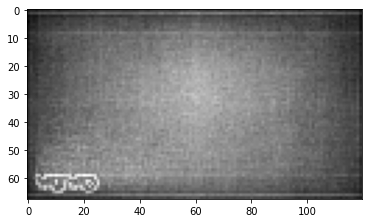

In [68]:
lines = []
for index in range(gb_images.shape[0]):
    if not gb_images["error"].iloc[index][0]:
        image_path = gb_images["thumbnail_path"].iloc[index][0]
        img = cv2.imread(image_path,0)
        if img.shape[:2] != (90,120): continue
        img = img[11:-11,:]
        edges = cv2.Canny(img,100,200)
        lines.append(edges)
        
edges_mean = np.mean(lines, axis = 0)
plt.imshow(edges_mean, 'gray')
plt.show()